# Creating a Heatmap of Vector Results

In this notebook, you'll learn how to use Planet's [Analytics API](https://developers.planet.com/docs/analytics/) to display a heatmap of vector analytic results, specifically buildng change detections. This can be used to identify where the most change is happining.



Open this notebook in Colab below:

<a target="_blank" href="https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/analytics/change_detection_heatmap.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setup


### Install additional dependencies

Install `cartopy` v0.18 beta, so that we can render OSM tiles under the heatmap:

In [1]:
!pip install cython
!pip install https://github.com/SciTools/cartopy/archive/v0.18.0.zip

  Using cached https://github.com/SciTools/cartopy/archive/v0.18.0.zip
  Preparing metadata (setup.py) ... done


### Import Packages

In [2]:
import os
import requests
import statistics
import pyproj
import matplotlib.pylab as pl
import numpy as np

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import shapely

### API configuration

Before getting items from the API, you must set your `API_KEY` and the `SUBSCRIPTION_ID` of the analytic feed change detection subscription to use.
If you want to limit the heatmap to a specific time range, also set `TIMES` to a [valid time range](https://developers.planet.com/docs/analytics/reference/#tag/Results%2Fpaths%2F~1collections~1%7BsubscriptionID%7D~1items~1%2Fget).

In [3]:
if os.environ.get('PL_API_KEY', ''):
    API_KEY = os.environ.get('PL_API_KEY', '')
else:
    API_KEY = 'YOUR_API_KEY_HERE'

# We'll use a subscriptions ID looking at monthly building construction in Melbourne, Australia
SUBSCRIPTION_ID = "dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5"
TIMES = None

planet = requests.session()
planet.auth = (API_KEY, '')

## Fetch Items

Next, we fetch the items from the API in batches of 500 items, and return only the relevant data - the centroid and the calculated area. This might take a few minutes to run, as some change detection feeds have thousands of items.

In [4]:
def get_next_url(result):
    """
    Retrieves the URL of the next page from the result object, 
    ensuring pagination is taken into account.

    Args:
        result (dict): The result object containing the links.

    Returns:
        str: The URL of the next page if it exists, None otherwise.
    """
    if 'links' in result:
        for link in result['links']:
            if link['rel'] == 'next':
                return link['href']

def get_items_from_feed():
    """
    Fetches items from a feed URL and extracts relevant information.

    Returns:
        list: A list of dictionaries representing the extracted items.
    """
    url = 'https://api.planet.com/analytics/collections/{}/items?limit={}'.format(
        SUBSCRIPTION_ID, 500)
    if TIMES:
        url += '&datetime={}'.format(TIMES)

    print("Fetching items from " + url)
    
    result = planet.get(url).json()
        
    items = []
    while len(result.get('features', [])) > 0:
        for f in result['features']:
            coords = f['geometry']['coordinates'][0]
            items.append({
                'lon': statistics.mean([c[0] for c in coords]),
                'lat': statistics.mean([c[1] for c in coords]),
                'area': shapely.geometry.shape(f['geometry']).area
            })
        url = get_next_url(result)
        if not url:
            return items
        print("Fetching items from " + url)
        result = planet.get(url).json()

        
items = get_items_from_feed()
print("Fetched " + str(len(items)) + " items")
# Get the bounding box coordinates of this AOI.
url = 'https://api.planet.com/analytics/subscriptions/{}'.format(SUBSCRIPTION_ID)
result = planet.get(url).json()
geometry = result['geometry']

Fetching items from https://api.planet.com/analytics/collections/dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5/items?limit=500
Fetching items from https://api.planet.com/analytics/collections/dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5/items?before=d53c7b64-0ae5-4fd6-afe7-ea9a1effface&limit=500
Fetching items from https://api.planet.com/analytics/collections/dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5/items?before=66db55b2-57ed-4a76-b78d-54456431f0d9&limit=500
Fetching items from https://api.planet.com/analytics/collections/dd2878b3-eaf0-4cff-b7f9-7a39d6f460a5/items?before=3c3669cc-bbfc-4a2d-afbf-772091e29108&limit=500
Fetched 1730 items


## Displaying the Heatmap

Once you've fetched all the items, you are nearly ready to display them as a heatmap.

### Coordinate Systems

The items fetched from the API are in WGS84 (lat/lon) coordinates. However, it can be useful to display the data in  an equal area projection like EPSG:3857 so that the heatmap shows change per square meter.

To do this, we use [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) to transfrom the item coordinates between projections.

In [5]:
SRC_PROJ = 'EPSG:4326'
DEST_PROJ = 'EPSG:3857'
PROJ_UNITS = 'm'

transformer = pyproj.Transformer.from_crs(SRC_PROJ, DEST_PROJ, always_xy=True)

### Colormap

Matplotlib provides a number of colormaps that are useful to render heatmaps. However, all of these are solid color - in order to see an underlying map, we need to add an alpha chanel.

For this example, we will use the "plasma" colormap, and add a transparent gradient to the first half of the map, so that it starts out completely transparent, and gradually becomes opaque, such that all values above the midpoint have no transparency.

In [6]:
src_colormap = pl.cm.plasma
alpha_vals = src_colormap(np.arange(src_colormap.N))
alpha_vals[:int(src_colormap.N/2),-1] = np.linspace(0, 1, int(src_colormap.N/2))
alpha_vals[int(src_colormap.N/2):src_colormap.N,-1] = 1
alpha_colormap = ListedColormap(alpha_vals)

### Heatmap configuration

**Note**: These final four sections are presented together in one code block, to make it easier to re-run with different configurations of bounds or intervals.

Set `BOUNDS` to the area of interest to display `(min lon,max lon,min lat,max lat)`. The default bounds are centered on Sydney, Australia - you should change this to match the AOI of your change detection subscription feed.

Set `INTERVALS` to the number of bins along the x-axis. Items are categorized into equal-size square bins based on this number of intervals and the aspect ratio of your bounds. For a square AOI, the default value of `INTERVALS = 36` would give 36 * 36 = 1296 bins; an AOI with the same width that is half as tall would give 36 * 18 = 648 bins.
The area (in square meters) of each bin is displayed in the legend to the right of the plot.

### Categorization

This configuration is used to categorize the items into bins for display as a heatmap.

1. The bounds and intervals are used to generate an array of midpoints representing the bins.
2. Categorize the items retrieved from the API into these  bins based on which midpoint they are closest to.
3. Aggregate up the areas of all the items in each bin.
4. Convert the resulting data into an xy grid of areas and fill in missing cells with zeros.

### OSM Basemap

So that we can see where our heatmap values actually are, we will [use cartopy to display OSM tiles](../webtiles/osm_basemap.ipynb) underneath the heatmap. Note that this requires an internet connection.

For an offline alternative, you could plot a [vector basemap](../vector/shapefile.ipynb) or imshow to display a local raster image.

### Display Heatmap

The final step is to display the grid data as a heatmap, using [imshow](https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.pyplot.imshow.html). You can use the parameters here to change how the heatmap is rendered. For example, chose a different `cmap` to change the color, or add the `interpolation='bicubic'` parameter to display smooth output instead of individual pixels.

To make it clear where the heatmap is being displayed, use [Natural Earth](https://www.naturalearthdata.com/) 1:110m datasets to render a map alongside the heatmap data.

16113384.184684878 16162303.88278739 -4528893.9258967 -4483031.708925587


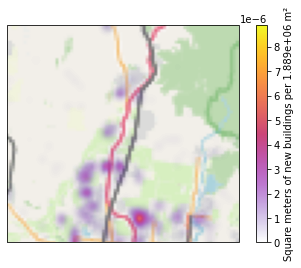

In [7]:
%matplotlib inline

# Heatmap Configuration
RAW_BOUNDS = shapely.geometry.shape(geometry).bounds
INTERVALS: int = 36

BOUNDS = [0.] * 4
BOUNDS[0],BOUNDS[2] = transformer.transform(RAW_BOUNDS[0],RAW_BOUNDS[1])
BOUNDS[1],BOUNDS[3] = transformer.transform(RAW_BOUNDS[2],RAW_BOUNDS[3])
print (BOUNDS[0], BOUNDS[1], BOUNDS[2], BOUNDS[3])


# Categorization

# 1. Generate bins from bounds + intervals
aspect_ratio = (BOUNDS[1] - BOUNDS[0]) / (BOUNDS[3] - BOUNDS[2])
x_bins = np.linspace(BOUNDS[0], BOUNDS[1], INTERVALS, endpoint=False)
y_bins = np.linspace(BOUNDS[2], BOUNDS[3], int(INTERVALS/aspect_ratio), endpoint=False)

x_delta2 = (x_bins[1] - x_bins[0])/2
y_delta2 = (y_bins[1] - y_bins[0])/2
x_bins = x_bins + x_delta2
y_bins = y_bins + y_delta2


# 2. Categorize items in bins
binned = []
for f in items:
    fx,fy = transformer.transform(f['lon'], f['lat'])
    if (BOUNDS[0] < fx < BOUNDS[1]) and (BOUNDS[2] < fy < BOUNDS[3]):
        binned.append({
            'x': min(x_bins, key=(lambda x: abs(x - fx))),
            'y': min(y_bins, key=(lambda y: abs(y - fy))),
            'area': f['area']
        })

# 3. Aggregate binned values
hist = pd.DataFrame(binned)
hist = hist.groupby(['x', 'y']).sum().reset_index()

# 4. Pivot into an xy grid and fill in empty cells with 0.
hist = hist.pivot(index = 'y', columns = 'x', values = 'area').fillna(0)
hist = hist.reindex(y_bins, axis=0, fill_value=0).reindex(x_bins, axis=1, fill_value=0).fillna(0)

# OSM Basemap
osm_tiles = cimgt.OSM()
carto_proj = ccrs.GOOGLE_MERCATOR

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=carto_proj)
ax.axis(BOUNDS)

tile_image = ax.add_image(osm_tiles, 8)

# Display Heatmap
heatmap = ax.imshow(hist.values, zorder=1, aspect='equal', origin='lower', extent=BOUNDS, cmap=alpha_colormap, interpolation='bicubic')
plt.colorbar(heatmap, ax=ax).set_label("Square meters of new buildings per {:.3e} {}²".format(4 * x_delta2 * y_delta2,PROJ_UNITS))